In [1]:
# Read crawled tweets from the dataset
# WARNING: Reading tweets takes up nearly 30GB of RAM space, with the provided dataset.

import pandas as pd
# data = pd.read_csv('russo_ukraine.csv', compression='gzip', dtype=str)

# data_list_raw = []
# for i in range(1, 20):
# 	filename = f'snsc_data/out_{i}.csv'
# 	print('Reading file:', filename)
# 	d = pd.read_csv(filename, compression='gzip', dtype=str)
# 	data_list_raw.append(d)

# data = pd.concat(data_list_raw, axis=0, ignore_index=True)
# # Remove tweets with invalid "create_at" time
# data = data[data.created_at.str.contains(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\+00:00$')]
# data.to_csv('snsc_data/out_full.csv', index=False, compression='gzip')

data = pd.read_csv('snsc_data/out_full.csv', compression='gzip', dtype=str)
print(data.shape)

(1914282, 419)


In [2]:
# Time range of the data

print(data.created_at.min())
print(data.created_at.max())

2022-03-17 10:05:14+00:00
2022-03-17 15:21:58+00:00


In [3]:
# Some analysis

data[data.entities_hashtags.str.contains('p2p', na=False)].text.to_list()

['#IDO #Airdrop #Whitelist #NFT #p2pquake',
 '#IDO #Airdrop #Whitelist #NFT #p2pquake']

In [4]:
# List all hashtags

import ast
all_hashtags_raw = data.query('entities_hashtags.notna() and entities_hashtags != "[]"').entities_hashtags.to_list()
all_hashtags_raw = list(map(lambda raw_str: ast.literal_eval(raw_str), all_hashtags_raw))
all_hashtags_count = {}
for hashtags_raw in all_hashtags_raw:
	hashtags = map(lambda d: d['text'].lower(), hashtags_raw)
	for hashtag in hashtags:
		if hashtag not in all_hashtags_count: all_hashtags_count[hashtag] = 0
		all_hashtags_count[hashtag] += 1
all_hashtags = list(all_hashtags_count.keys())
print('Num of distinct hashtags:', len(all_hashtags))

Num of distinct hashtags: 19852


In [5]:
# Remove non-English hashtags

import re
for hashtag in all_hashtags.copy():
	if re.search('[^0-9A-Za-z_]', hashtag) is not None:
		all_hashtags.remove(hashtag)
		all_hashtags_count.pop(hashtag)

print('Num of distinct English hashtags:', len(all_hashtags))

Num of distinct English hashtags: 16971


In [6]:
# Manually remove hashtags that are irrelevant

irrelevant_hashtags = ['javascript', '100daysofcode', 'womenwhocode', 'coding', 'pytorch', 'java', 'airdrop', 'p2p']

for hashtag in irrelevant_hashtags:
	if hashtag in all_hashtags:
		all_hashtags.remove(hashtag)
		all_hashtags_count.pop(hashtag)

In [7]:
# Filter top 1% frequent hashtags for analysis

all_hashtags_count_sorted = sorted(list(all_hashtags_count.items()), key=lambda pair: -pair[1])
num_top = int(len(all_hashtags) * 0.01)
target_hashtags_count = all_hashtags_count_sorted[:num_top]
target_hashtags_dict = dict(target_hashtags_count)
target_hashtags = list(map(lambda tup: tup[0], target_hashtags_count))

print(num_top)
print(target_hashtags_count)

169
[('ukraine', 69024), ('russia', 26764), ('putin', 14090), ('russian', 10028), ('ukrainian', 7166), ('mariupol', 7082), ('ukrainerussiawar', 7024), ('kyiv', 6192), ('standwithukraine', 5762), ('zelensky', 5228), ('nestle', 4981), ('stpatricksday', 4848), ('nato', 4620), ('nft', 4356), ('breaking', 3842), ('ukrainewar', 3312), ('usa', 3100), ('selenskyj', 3050), ('flagnetwork', 2896), ('ukraineunderattack', 2884), ('stoprussia', 2432), ('bitcoin', 2415), ('mykolaiv', 2376), ('bundestag', 2370), ('ireland', 2314), ('putinwarcriminal', 2312), ('biden', 2300), ('kherson', 2252), ('stopthewar', 2228), ('ucraina', 2172), ('stopwar', 2170), ('tigrayfamine', 2087), ('freeukraine', 1966), ('stopputin', 1934), ('russie', 1882), ('us', 1872), ('rusia', 1862), ('ido', 1848), ('ucrania', 1842), ('kharkiv', 1832), ('kiev', 1804), ('moldova', 1804), ('tigray', 1662), ('standwithukriane', 1642), ('russiaukrainewar', 1632), ('weareallukrainians', 1508), ('cryptocurrency', 1504), ('anonymous', 1500),

In [8]:
# Merge hashtags that has the same meaning

merge_hashtags = {
	'nfts': 'nft',
	'ukrainerussianwar': 'ukrainerussiawar',
	'ucraina': 'ukraina',
	'ucrania': 'ukraina',
	'ukrayna': 'ukraina',
	'russians': 'russian',
	'ukrainians': 'ukrainian',
	'selenskyj': 'zelensky',
	'zelenskyy': 'zelensky',
	'standwithukriane': 'standwithukraine',
	'warcriminal': 'warcrimes',
}

for hashtag in merge_hashtags.keys():
	target_hashtags.remove(hashtag)
	target_hashtags_dict[merge_hashtags[hashtag]] += target_hashtags_dict[hashtag]
	target_hashtags_dict.pop(hashtag)
target_hashtags_count = list(target_hashtags_dict.items())
print('Num of nodes after removing duplicates:', len(target_hashtags))

Num of nodes after removing duplicates: 158


In [9]:
# Find co-occurrence numbers as edge weights
hashtag_pairs = {}

for hashtags_raw in all_hashtags_raw:
	if len(hashtags_raw) == 1: continue

	for xi in range(len(hashtags_raw) - 1):
		x = hashtags_raw[xi]['text'].lower()
		if x in merge_hashtags: x = merge_hashtags[x]
		if x not in target_hashtags: continue
		for yi in range(xi + 1, len(hashtags_raw)):
			y = hashtags_raw[yi]['text'].lower()
			if y in merge_hashtags: y = merge_hashtags[y]
			if y not in target_hashtags or x == y: continue

			tx, ty = (x, y) if x < y else (y, x)
			if (tx, ty) not in hashtag_pairs: hashtag_pairs[(tx, ty)] = 0
			hashtag_pairs[(tx, ty)] += 1

print('Num of edges:', len(hashtag_pairs))
sum_edge_weights = sum(hashtag_pairs.values())
print('Sum of all edge weights:', sum_edge_weights)

Num of edges: 2769
Sum of all edge weights: 246745


In [10]:
# Remove separated hashtags (no edge connect to)

target_hashtags_separated = target_hashtags.copy()
for x, y in hashtag_pairs.keys():
	if x in target_hashtags_separated:
		target_hashtags_separated.remove(x)
	if y in target_hashtags_separated:
		target_hashtags_separated.remove(y)

target_hashtags = list(set(target_hashtags) - set(target_hashtags_separated))
# for hashtag in target_hashtags_separated:
# 	if hashtag in target_hashtags_dict:
# 		target_hashtags_dict.pop(hashtag)
# target_hashtags_count = list(target_hashtags_dict.items())

print('Num of hashtags after removal:', len(target_hashtags))
print('Removed hashtags:', ' '.join(target_hashtags_separated))

Num of hashtags after removal: 155
Removed hashtags: savesoil ukrainianheroes coronabedrog


Minimum edge weight: 2
Maximum edge weight: 8438


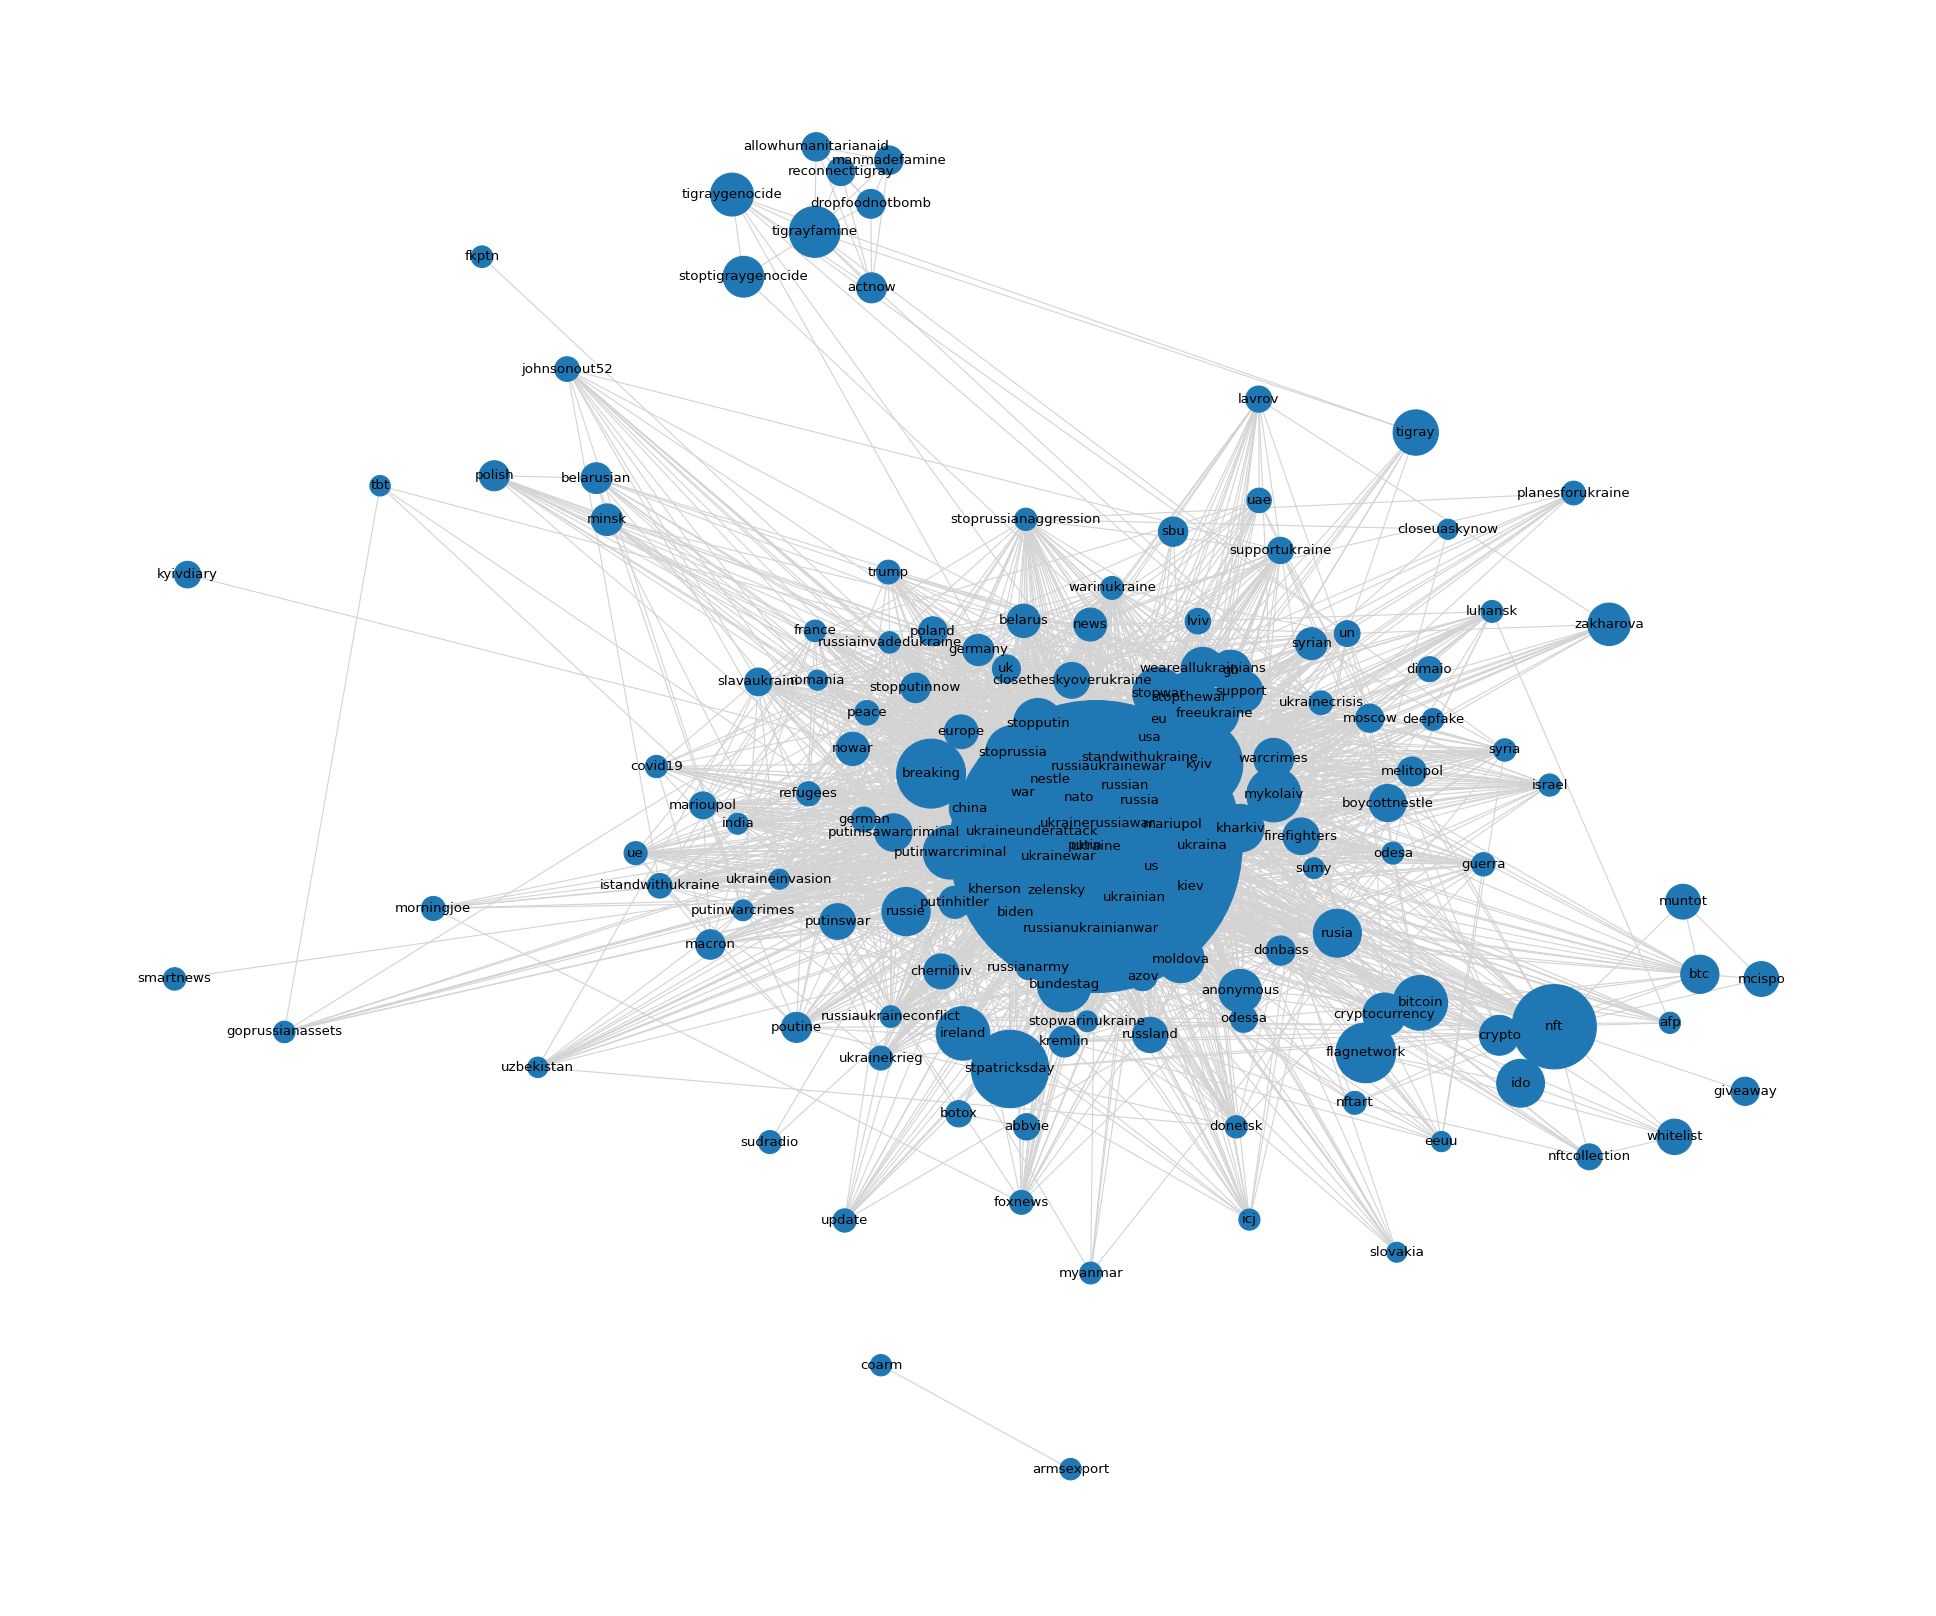

In [11]:
# Draw networkx graph

import networkx as nx
import matplotlib.pyplot as plt

# To construct reverse weights, find the maximum weights first
minimum_weight = min(hashtag_pairs.values())
maximum_weight = max(hashtag_pairs.values())
print('Minimum edge weight:', minimum_weight)
print('Maximum edge weight:', maximum_weight)

G = nx.Graph()
for hashtag, count in target_hashtags_count:
	if hashtag in target_hashtags:
		G.add_node(hashtag, weight=count)
for hashtag_pair, weight in hashtag_pairs.items():
	G.add_edge(*hashtag_pair, weight=weight, reverse_weight=maximum_weight - weight)

pos = nx.spring_layout(G, k=2.2)
plt.figure(figsize=(24, 20), dpi=80)
nx.draw(
	G,
	pos=pos,
	with_labels=True,
	node_size=list(nx.get_node_attributes(G, 'weight').values()),
	edge_color='lightgrey',
)

In [12]:
# Compute network properties

print('Network density:', nx.density(G))
print('Network transitivity:', nx.transitivity(G))

Network density: 0.23200670297444492
Network transitivity: 0.5345974424423795


In [13]:
# Compute network centrality

import math

# Reference: https://gist.github.com/aldous-rey/e6ee7b0e82e23a686d5440bf3987ee23
def get_centrality(centrality, c_type):
	c_denominator = float(1)

	n_val = float(len(centrality))

	# print(str(len(centrality)) + ", " +  c_type)

	if (c_type == "degree"):
		c_denominator = n_val-2

	if (c_type == "close"):
		c_top = (n_val-1)*(n_val-2)
		c_bottom = (2*n_val)-3
		c_denominator = float(c_top/c_bottom)

	if (c_type == "between"):
		c_denominator = (n_val*n_val*(n_val-2))

	if (c_type == "eigen"):
		'''
		M = nx.to_scipy_sparse_matrix(G, nodelist=G.nodes(),weight='weight',dtype=float)
		eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which='LR') 
		largest = eigenvector.flatten().real
		norm = sp.sign(largest.sum())*sp.linalg.norm(largest)
		centrality = dict(zip(G,map(float,largest)))
		'''
		c_denominator = math.sqrt(2) / 2 * (n_val - 2)


	# start calculations
	c_node_max = max(centrality.values())
	c_sorted = sorted(centrality.values(),reverse=True)
	# print("max node:", c_node_max)

	c_numerator = 0
	for value in c_sorted:
		c_numerator += c_node_max - value

	# print('numerator:', c_numerator)
	# print('denominator:', c_denominator)
	
	network_centrality = c_numerator / c_denominator
	if c_type == "between":
		network_centrality = network_centrality * 2

	return network_centrality


print('Degree centrality:', get_centrality(nx.degree_centrality(G), 'degree'))
print('Betweenness centrality:', get_centrality(nx.betweenness_centrality(G, normalized=False), 'between'))
print('Closeness centrality:', get_centrality(nx.closeness_centrality(G), 'close'))

Degree centrality: 0.6398862575333163
Betweenness centrality: 0.11742559011615235
Closeness centrality: 0.6749688661250649


In [14]:
# Compute centrality using reverse weights
print('Weighted betweenness centrality:', get_centrality(nx.betweenness_centrality(G, weight='reverse_weight', normalized=False), 'between'))
print('Weighted closeness centrality:', get_centrality(nx.closeness_centrality(G, distance='reverse_weight'), 'close'))

Weighted betweenness centrality: 0.5797858984037609
Weighted closeness centrality: 9.119029050303067e-05


In [15]:
# Import categories

import yaml

with open('hashtag_categories.yaml', encoding='utf-8') as f:
	hashtag_categories = yaml.safe_load(f)

hashtag_categories_all = []
for hashtags in hashtag_categories.values():
	hashtag_categories_all.extend(hashtags)
assert sorted(hashtag_categories_all) == sorted(target_hashtags + target_hashtags_separated)

print('Categories frequency:')
categories_frequency = {}
target_hashtags_count_sum = sum(target_hashtags_dict.values())
for category, hashtags in hashtag_categories.items():
	categories_frequency[category] = sum([target_hashtags_dict[hashtag] for hashtag in hashtags])
	print(f'{category}: {categories_frequency[category]}, {categories_frequency[category]/target_hashtags_count_sum:.6f}')

Categories frequency:
civil: 2638, 0.007956
economy: 15997, 0.048248
event: 33821, 0.102005
geolocation: 148428, 0.447664
government: 11940, 0.036011
identity: 24894, 0.075081
media: 16400, 0.049463
public: 29648, 0.089419
standpoint: 36307, 0.109503
time: 6610, 0.019936
other: 4878, 0.014712


In [16]:
# Girvan-Newman
# Note: this step takes up around 10 minutes

cluster_size_limit = 11

def get_max_edge_betweenness(G: nx.Graph):
	centrality = nx.edge_betweenness_centrality(G, weight='reverse_weight')
	return max(centrality, key=centrality.get)

gn_clusters = nx.algorithms.community.girvan_newman(G, get_max_edge_betweenness)
gn_target_clusters = []
for clusters in gn_clusters:
	max_cluster_size = max([len(nodes) for nodes in clusters])
	if max_cluster_size > cluster_size_limit:
		continue
	gn_target_clusters = list([sorted(nodes) for nodes in clusters])
	break

gn_target_clusters.sort(key=lambda c: len(c), reverse=True)
print(gn_target_clusters)

[['boycottnestle', 'nowar', 'putinswar', 'russiainvadedukraine', 'russiaukrainewar', 'stopputinnow', 'stopwarinukraine', 'ukrainecrisis', 'ukrainian', 'war', 'warcrimes'], ['closetheskyoverukraine', 'eu', 'europe', 'mariupol', 'peace', 'russie', 'stoprussianaggression', 'supportukraine', 'ukraineinvasion', 'warinukraine'], ['actnow', 'allowhumanitarianaid', 'dropfoodnotbomb', 'manmadefamine', 'reconnecttigray', 'tigrayfamine'], ['breaking', 'india', 'israel', 'uk', 'ukrainewar'], ['anonymous', 'ireland', 'nestle', 'stopputin'], ['flagnetwork', 'ido', 'whitelist'], ['russianukrainianwar', 'stopthewar'], ['crypto', 'kiev'], ['tigray', 'tigraygenocide'], ['mcispo', 'muntot'], ['german', 'moscow'], ['abbvie', 'botox'], ['armsexport', 'coarm'], ['ukraine'], ['russia'], ['putin'], ['russian'], ['ukrainerussiawar'], ['kyiv'], ['standwithukraine'], ['zelensky'], ['stpatricksday'], ['nato'], ['nft'], ['usa'], ['ukraineunderattack'], ['stoprussia'], ['bitcoin'], ['mykolaiv'], ['bundestag'], ['pu

In [17]:
# Girvan-Newman: analyze clusters

hashtag_to_category = {}
for category, hashtags in hashtag_categories.items():
	for hashtag in hashtags:
		hashtag_to_category[hashtag] = category

gn_target_clusters_category = []
for cluster in gn_target_clusters:
	categories = list(map(lambda hashtag: hashtag_to_category[hashtag], cluster))
	gn_target_clusters_category.append(sorted(categories))

for cluster in gn_target_clusters_category:
	if len(cluster) < 2: break
	print(f'[{len(cluster)}] ' + ', '.join(cluster))

[11] event, event, event, event, event, event, identity, standpoint, standpoint, standpoint, time
[10] civil, event, geolocation, geolocation, geolocation, government, standpoint, standpoint, standpoint, standpoint
[6] event, event, event, event, standpoint, time
[5] event, geolocation, geolocation, government, media
[4] event, geolocation, identity, standpoint
[3] economy, event, other
[2] event, standpoint
[2] economy, media
[2] event, geolocation
[2] other, other
[2] geolocation, identity
[2] event, media
[2] government, identity


In [18]:
# Export graph node attributes and edges for ERGM analysis

# Export node attributes
with open('nodes_attr.tsv', 'w', encoding='utf-8') as f:
	for hashtag, count in target_hashtags_count:
		if hashtag in target_hashtags:
			f.write(f'{hashtag}\t{hashtag_to_category[hashtag]}\t{count}\n')

# Export edges
with open('edges_list.tsv', 'w', encoding='utf-8') as f:
	for hashtag_pair, count in hashtag_pairs.items():
		f.write(f'{hashtag_pair[0]}\t{hashtag_pair[1]}\t{count}\n')